# Recommendation System


In [29]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pylab as plt
from time import time

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert

from nltk.corpus import stopwords
import numpy as np
import re

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

#### Reading and Exploring the dataset

In [30]:
df = pd.read_csv('goodreads_reviews_spoiler.csv', )
# df = pd.read_csv('cleaned.csv')
df = df[df['review_sentences'].notna()]

In [31]:
df.head(2)

,user_id,timestamp,review_sentences,rating,has_spoiler,book_id,review_id
0,8842281e1d1347389f2ab93d60773d4d,2017-08-30,"[[0, 'This is a special book.'], [0, 'It start...",5,True,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb
1,8842281e1d1347389f2ab93d60773d4d,2017-03-22,"[[0, 'Recommended by Don Katz.'], [0, 'Avail f...",3,False,16981,a5d2c3628987712d0e05c4f90798eb67


## 1. EDA

In [48]:
ratings = df.groupby('rating').rating.count()

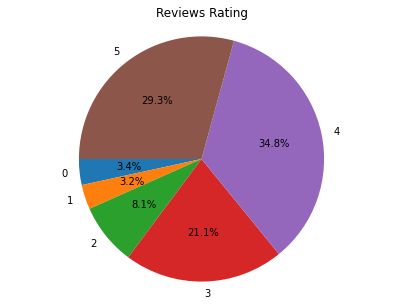

In [62]:
fig1, ax1 = plt.subplots(figsize =(7, 5))
ax1.pie(ratings, labels = ratings.index, autopct='%1.1f%%', startangle=180)
ax1.axis('equal')
ax1.set_title('Reviews Rating')
plt.show()

In [10]:
has_spoiler = df.groupby('has_spoiler').rating.count()

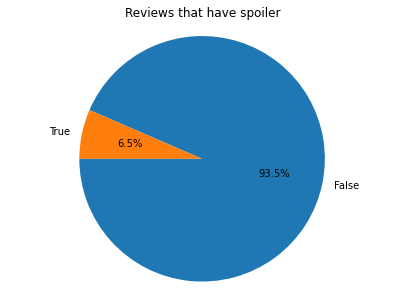

In [11]:
fig1, ax1 = plt.subplots(figsize =(7, 5))
ax1.pie(has_spoiler, labels = has_spoiler.index, autopct='%1.1f%%',startangle=180)
ax1.axis('equal')
ax1.set_title('Reviews that have spoiler')
plt.show()

In [6]:
time_stamp = pd.to_datetime(df['timestamp'])
time_stamp = time_stamp.apply(lambda time: time.year)

In [7]:
def plot_freq_bar(x, y, title, scale='linear', figsize=(10, 5), rotation=True, xlabel='', ylabel=''):
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.barplot(x=x, y=y, ax=ax)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    if rotation:
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.yscale(scale)
    plt.grid()

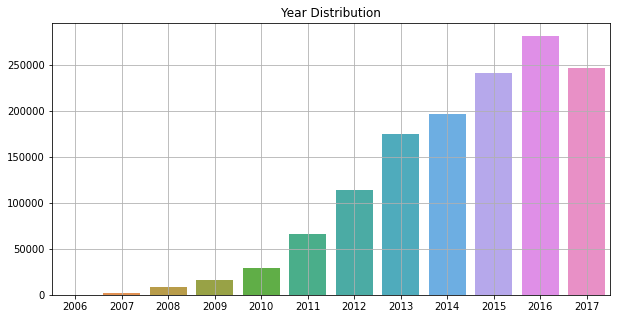

In [9]:
plot_freq_bar(time_stamp.value_counts().index, time_stamp.value_counts(), 'Year Distribution', rotation=False)

## 2. Recommenders

## 2.1. Item-Based Collaborative Filtering

### 2.1.1. Convert the dataset to an vectorization matrix
The fundamental assumption for this method is that a user gives similar ratings to similar books, i.e. `Each vector represents the set of books rated by a user`

In [32]:
df = df.drop(['timestamp', 'review_sentences','has_spoiler','review_id'], axis=1)

In [ ]:
views = pd.DataFrame(0, index=df.user_id, columns=df.book_id)
views = views[~views.index.duplicated(keep='first')]
views.head()

In [7]:
for user_id in views.index:
    user_books = df.loc[df['user_id'] == user_id]
    for book_id, rating in list(zip(user_books['book_id'],user_books['rating'])):
        views.loc[user_id, book_id] = rating
views = views[~views.index.duplicated(keep='first')]        

In [8]:
# views = views.T
# views.index = views.index.map(str)

In [9]:
views.head()

book_id,18245960,16981,28684704,27161156,25884323,19398490,22318578,24189224,22551730,22816087,...,20958632,12954620,16238648,10194157,16034235,15793231,17675462,18490681,18392495,9462812
user_id,,,,,,,,,,,,,,,,,,,,,
8842281e1d1347389f2ab93d60773d4d,5,3,3,0,4,4,5,0,4,5,...,0,0,0,0,0,0,0,0,0,0
01ec1a320ffded6b2dd47833f2c8e4fb,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83d6e6f80d7c32c6676b3ab3b01543cd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2f6af21d14c83a5df6cdcef5e6af0b3e,0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
8e1db93d364acf3893ce998ebb8d57fc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.1.2. Making Friends Recommender `friends'suggestion` 😁
The `NearestNeighbors` in the sklearn.neighbors library can be used to calculate the distance between users using the **cosine similarity** and find the nearest neighbors for each user.

In [10]:
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(views.values)
distances, indices = knn.kneighbors(views.values, n_neighbors=10)

In [11]:
def get_similar_users(user_id):  
    
    index_for_user = views.index.tolist().index(user_id)
    
    sim_user = indices[index_for_user].tolist()
    
    user_distances = distances[index_for_user].tolist()
    
    id_user = sim_user.index(index_for_user)
    
    sim_user.remove(index_for_user)
    
    user_distances.pop(id_user)
    
    print(f'Similar Users to {user_id}:')
    
    for idx,value in list(zip(sim_user, user_distances)):
        print(views.index[idx], ' ', value)

In [14]:
get_similar_users('83d6e6f80d7c32c6676b3ab3b01543cd')

Similar Users to 83d6e6f80d7c32c6676b3ab3b01543cd:
9c339ce612647625f76e089e5bf2e33a   0.7183559266552417
ab68831437ee3b3458d65110e5b399d2   0.7197808449673089
68f9915717ccc347b5f46f1b11ec40fe   0.74091745870621
aea49e87a5738cc409a791f96ce85348   0.7427339965676776
b59a9a75f9fdb79d59d743e62fd427bf   0.7511594609002863
81cb77b9b154476c082d10dfa0f64b22   0.7543925159310233
62a410b4c521fe574b5aa89f42fdd2a5   0.7554300817922166
c1007aea1f43026867f32328dfd55cd5   0.7722793828442025
f4d95e562e14658c1e9b20f3f6f548f2   0.7723224854543317


## 2.2. Content Based Recommendation
### Recommendation system using `pre-trained BERT` Vectorizer

### 2.2.1. Reviews Pre-processing 

In [57]:
def preprocess_text(sen):
    sentence = re.compile(r'<[^>]+>').sub('', sen)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [66]:
# convert to the lower-case & remove the stop-words.
stop_words = set(stopwords.words('English'))
remove_stop_word = lambda x: ' '.join([word for word in x.split() if word not in stop_words])
df['review_sentences'] = df['review_sentences'].apply(lambda x: x.lower()).apply(remove_stop_word)

# preprocess reviews text
reviews = []
sentences = list(df['review_sentences'])
for sen in sentences:
    reviews.append(preprocess_text(sen))
    
df['review_sentences'] = reviews
# df.to_csv('cleaned.csv', header = True, index = False)

In [4]:
df.review_sentences[0]

'special book started slow first third middle third started get interesting last third blew mind love good science fiction pushes thinking things go hugo winner translated original chinese made interesting different way things read instance intermixing chinese revolutionary history kept accusing people reactionaries etc book science aliens science described book impressive book grounded physics pretty accurate far could tell though got folding protons dimensions think making stuff interesting think though would happen seti stations received message found someone person monitoring answering signal side disillusioned part book bit dark would like think human reaction discovering alien civilization hostile would like enders game would band together like book unveiled trisolaran culture game smart way build empathy also understand gone across many centuries know body problem unsolvable math problem still get made game maybe come next book loved quote long history scientific progress many p

#### Getting some testing samples

### 2.2.2 Calculating Reviews Similarities using BERT Vectorizer    `Suggest similar books` 🤓

In [6]:
def most_similar(idx, similarity_matrix, count):
    print (f'Similar Books to {df.iloc[idx]["book_id"]}:')
    similar_ix=np.argsort(similarity_matrix[idx])[::-1]
    for ix in similar_ix[:count+1]:
        if ix != idx:
            print (f'Book ID : {df.iloc[ix]["book_id"]} Similarity: {similarity_matrix[idx][ix]}')

In [5]:
# sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
# sbert_model = SentenceTransformer('paraphrase-MiniLM-L3-v2')
sbert_model = SentenceTransformer('paraphrase-TinyBERT-L6-v2')

In [11]:
reviews_embeddings = sbert_model.encode(df.review_sentences)

In [12]:
len(reviews_embeddings[1])

768

In [14]:
pairwise_similarities = cosine_similarity(reviews_embeddings)

In [37]:
most_similar(5, pairwise_similarities, 6)

Similar Books to 19398490:
Book ID : 22388758 Similarity: 0.7332471609115601
Book ID : 163363 Similarity: 0.7270899415016174
Book ID : 19063 Similarity: 0.7268206477165222
Book ID : 8664353 Similarity: 0.7251172661781311
Book ID : 27362503 Similarity: 0.7132943868637085
Book ID : 22925912 Similarity: 0.7120002508163452


## 2.3. Collaborative Filtering using Surprise Library 

### 2.3.1. Converting the dataset into sparse matrix

In [34]:
user_id_le = LabelEncoder()
book_id_le = LabelEncoder()

In [35]:
spars_user_ids = user_id_le.fit_transform(df.user_id)

In [36]:
spars_book_ids = book_id_le.fit_transform(df.book_id)

In [37]:
df['user_id'] = spars_user_ids

In [38]:
df['book_id'] = spars_book_ids

In [39]:
df.head()

,user_id,rating,book_id
0,9983,5,15889
1,9983,3,711
2,9983,3,23331
3,9983,0,22616
4,9983,4,21992


In [40]:
df = df.astype({'user_id': 'int32', 'book_id': 'int32', 'rating': 'int16'})

### 2.3.2. Import the surprise library and let it do the rest of the work 😅

In [108]:
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate,  train_test_split
from collections import defaultdict

In [106]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'book_id', 'rating']], reader)
algo = SVD()

In [107]:
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1151  1.1167  1.1173  1.1164  0.0009  
MAE (testset)     0.8412  0.8427  0.8415  0.8418  0.0007  
Fit time          49.48   46.72   47.45   47.88   1.16    
Test time         4.89    4.82    4.73    4.82    0.07    


### 2.3.3. Calculating precision and recall


<img src="p&r@k.png" width="800" height="200">

#### 2.3.3.1. Definitions

- **Relevant items** are already known in the data set
    - Relevant item: Has a True/Actual rating >= threshold
    - Irrelevant item: Has a True/Actual rating < threshold

- **Recommended items** are generated by recommendation algorithm
    - Recommended item: has a predicted rating >= threshold
    - Not recommended item: Has a predicted rating < threshold
    
#### 2.3.4. References
1. Recall and Precision at k for Recommender Systems. [here](https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54)

2. How to compute precision@k and recall@k. [here](https://surprise.readthedocs.io/en/stable/FAQ.html?highlight=recall#how-to-compute-precision-k-and-recall-k)    

In [101]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [102]:
trainset, testset = train_test_split(data, test_size=.20)

In [103]:
algo = SVD()

In [104]:
algo.fit(trainset)
predictions = algo.test(testset)

In [105]:
precisions, recalls = precision_recall_at_k(predictions, k=12, threshold=2)
print('Precision:', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall:', sum(rec for rec in recalls.values()) / len(recalls))

Precision: 0.9374380005790537
Recall: 0.7985783090537663
